In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_folder = 'data'
site = 'power_avenal-movie-theatre'

# Import data

In [3]:
df_raw = pd.read_csv(data_folder + '/' + site + '.csv', index_col=[0], parse_dates=True)
df_raw = df_raw[(df_raw.index < '2019-04-01')]
df_raw.head()

,power
datetime,
2018-01-01 00:00:04.574889+00:00,400.0
2018-01-01 00:00:10.215095+00:00,440.0
2018-01-01 00:00:13.496753+00:00,440.0
2018-01-01 00:00:20.031088+00:00,440.0
2018-01-01 00:00:33.525473+00:00,400.0


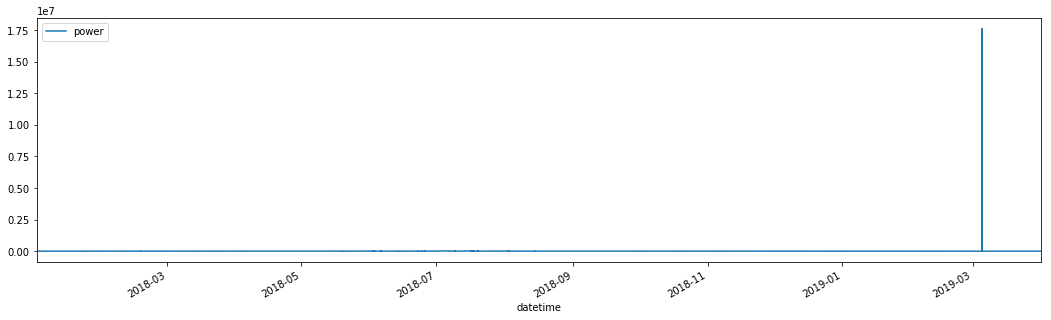

In [4]:
df_raw.plot(figsize=(18,5))

# Clean data

Resample data to 1hour interval, remove outliers and drop NaN's.

In [5]:
df_processed = df_raw.resample('1h').mean()
df_processed = df_processed[df_processed['power'] < 10000000]
df_processed = df_processed[(np.abs(stats.zscore(df_processed)) < float(3)).all(axis=1)]
df_processed.dropna(inplace=True)
df_processed.head()

,power
datetime,
2018-01-01 00:00:00+00:00,455.796767
2018-01-01 01:00:00+00:00,483.180723
2018-01-01 02:00:00+00:00,2206.981132
2018-01-01 03:00:00+00:00,2309.107551
2018-01-01 04:00:00+00:00,2538.070175


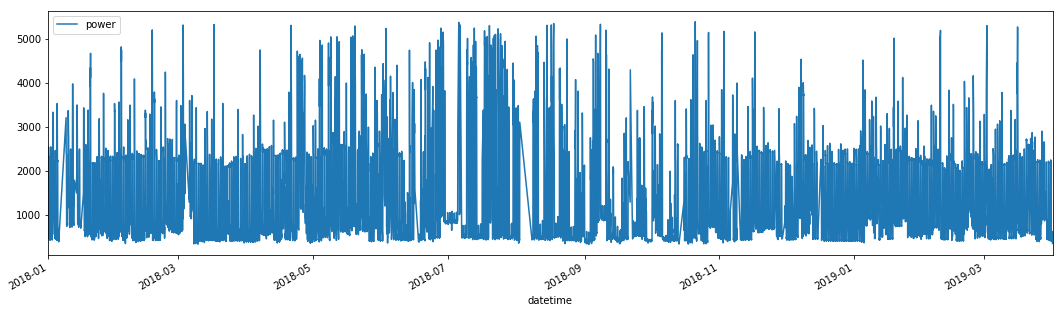

In [6]:
df_processed.plot(figsize=(18,5))

# Check for stationarity

if (Test Statistics < Critical Value (1%)):
    
    Data is stationary with 99% certainty
    
if p-value > 0.05:

    Cannot reject the null hypothesis (Null Hypothesis: Data is non-stationary)
    
In this case, since the Test Statistic is greater than the Critical Value (10%), and the p-value > 0.05, we can conclude that the data is non-stationary.

In [7]:
result = adfuller(df_processed['power'], autolag='AIC')
output = pd.Series(result[0:4], index=['Test Statistics', 'p-value', '#Lags Used',
                                      '#Observations Used'])
for key, value in result[4].items():
    output['Critical Value (%s)' % key] = value
    
output

Test Statistics        -1.265069e+01
p-value                 1.370449e-23
#Lags Used              3.900000e+01
#Observations Used      1.003200e+04
Critical Value (1%)    -3.431002e+00
Critical Value (5%)    -2.861828e+00
Critical Value (10%)   -2.566923e+00
dtype: float64

# Make data stationary

Test Statistics < Critical Value (1%) --> Data is stationary

In [8]:
df_stationary = df_processed.diff(1).dropna()

result = adfuller(df_stationary['power'], autolag='AIC')
output = pd.Series(result[0:4], index=['Test Statistics', 'p-value', '#Lags Used',
                                      '#Observations Used'])
for key, value in result[4].items():
    output['Critical Value (%s)' % key] = value
output

Test Statistics           -29.990150
p-value                     0.000000
#Lags Used                 30.000000
#Observations Used      10040.000000
Critical Value (1%)        -3.431001
Critical Value (5%)        -2.861828
Critical Value (10%)       -2.566923
dtype: float64

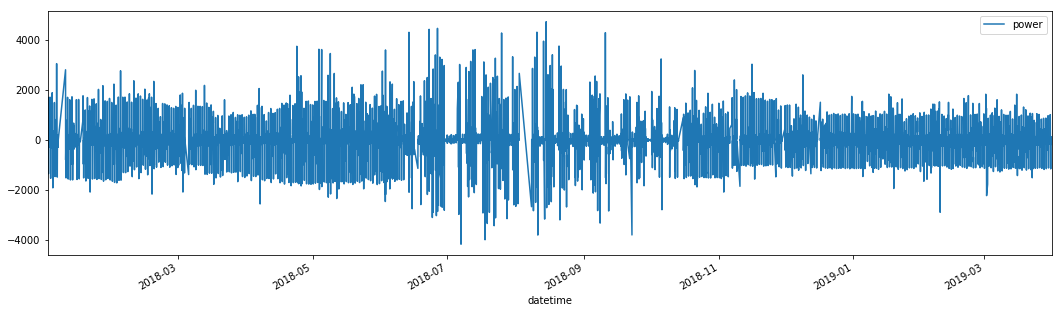

In [9]:
df_stationary.plot(figsize=(18,5))

# Normalize data

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
df_normalized = pd.DataFrame(scaler.fit_transform(df_processed), 
                             columns=df_processed.columns, index=df_processed.index)

In [11]:
result = adfuller(df_normalized['power'], autolag='AIC')
output = pd.Series(result[0:4], index=['Test Statistics', 'p-value', '#Lags Used',
                                      '#Observations Used'])
for key, value in result[4].items():
    output['Critical Value (%s)' % key] = value
    
output

Test Statistics        -1.265069e+01
p-value                 1.370449e-23
#Lags Used              3.900000e+01
#Observations Used      1.003200e+04
Critical Value (1%)    -3.431002e+00
Critical Value (5%)    -2.861828e+00
Critical Value (10%)   -2.566923e+00
dtype: float64

# ACF

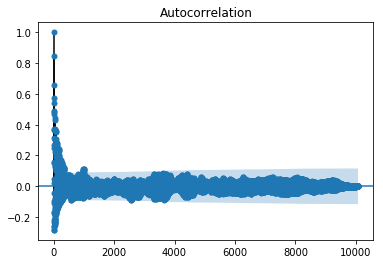

In [12]:
fig1 = plot_acf(df_normalized)

# PACF

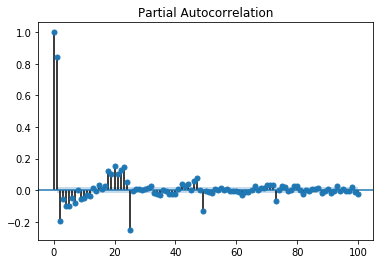

In [13]:
fig2 = plot_pacf(df_normalized, lags=100)

# Add time features?

# Add HVAC states?

# LSTM

In [14]:
train_size = int(0.8 * len(df_normalized.values))
training_set = df_normalized.values[:train_size]
X_train, y_train = [], []

for i in range(10, len(training_set)):
    X_train.append(training_set[i-10:i])
    y_train.append(training_set[i])
    
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0]))

print(X_train.shape)
print(y_train.shape)

(8047, 10, 1)
(8047,)


In [15]:
model = Sequential()

model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total para

In [17]:
model.fit(X_train, y_train, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
8047/8047 [==============================] - 6s 807us/step - loss: 0.0324
Epoch 2/10
8047/8047 [==============================] - 5s 605us/step - loss: 0.0165
Epoch 3/10
8047/8047 [==============================] - 5s 639us/step - loss: 0.0143
Epoch 4/10
8047/8047 [==============================] - 5s 664us/step - loss: 0.0141
Epoch 5/10
8047/8047 [==============================] - 5s 652us/step - loss: 0.0138
Epoch 6/10
8047/8047 [==============================] - 5s 646us/step - loss: 0.0135
Epoch 7/10
8047/8047 [==============================] - 5s 637us/step - loss: 0.0132
Epoch 8/10
8047/8047 [==============================] - 5s 618us/step - loss: 0.0132
Epoch 9/10
8047/8047 [==============================] - 5s 631us/step - loss: 0.0132
Epoch 10/10
8047/8047 [==============================] - 5s 633us/step - loss: 0.0132


In [18]:
testing_set = df_normalized.values[train_size:]
X_test, y_test = [], []

for i in range(10, len(testing_set)):
    X_test.append(testing_set[i-10:i])
    y_test.append(testing_set[i])
    
X_test, y_test = np.array(X_test), np.array(y_test)
    
# Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0]))

print(X_test.shape)
print(y_test.shape)

(2005, 10, 1)
(2005,)


In [19]:
y_pred_normalized = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_normalized)

df_y_pred = pd.DataFrame(y_pred, 
                         columns=df_normalized[train_size:].columns, 
                         index=df_normalized[train_size+10:].index)
df_y_pred.head()

,power
datetime,
2019-01-05 21:00:00+00:00,2438.594727
2019-01-05 22:00:00+00:00,2818.410400
2019-01-05 23:00:00+00:00,2830.234619
2019-01-06 00:00:00+00:00,2573.533936
2019-01-06 01:00:00+00:00,2607.562500


In [20]:
y_true = scaler.inverse_transform([y_test])
y_true_reshape = np.reshape(y_true, (y_true.shape[1], y_true.shape[0]))
df_y_test = pd.DataFrame(y_true_reshape, 
                         columns=df_normalized[train_size:].columns, 
                         index=df_normalized[train_size+10:].index)
df_y_test.head()

,power
datetime,
2019-01-05 21:00:00+00:00,2877.041801
2019-01-05 22:00:00+00:00,2984.615385
2019-01-05 23:00:00+00:00,2762.901099
2019-01-06 00:00:00+00:00,2872.123894
2019-01-06 01:00:00+00:00,3835.855856


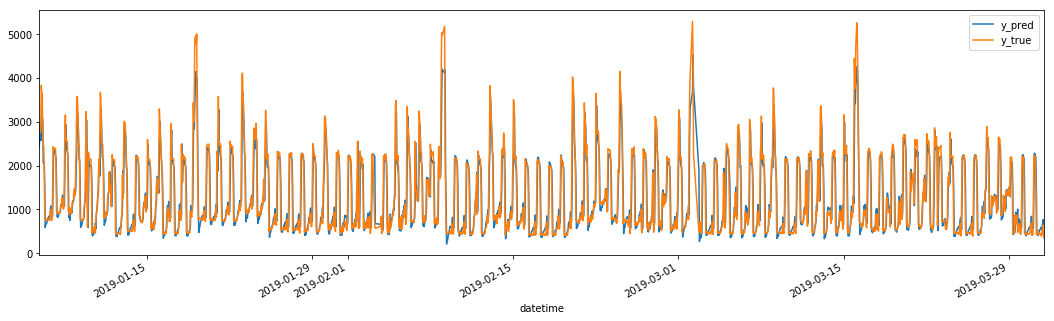

In [21]:
df_plot = pd.concat([df_y_pred, df_y_test], axis=1)
df_plot.columns = ['y_pred', 'y_true']
df_plot.plot(figsize=(18,5))

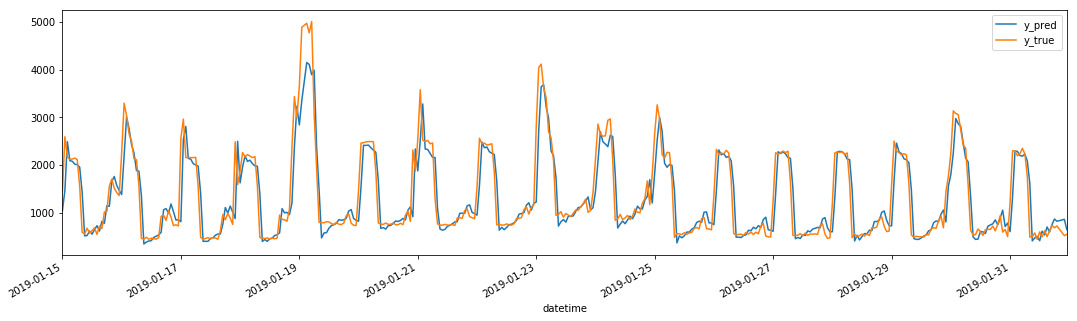

In [22]:
df_plot.loc['2019-01-15':'2019-01-31'].plot(figsize=(18,5))

In [23]:
from sklearn.metrics import mean_squared_error

mean_squared_error(df_y_pred, df_y_test)

166865.83987084695

In [24]:
from sklearn.metrics import r2_score

r2_score(df_y_pred, df_y_test)

0.7297377660627746